_Ce notebook a été créé par Yann Vernaz (2017)._

<center>
<a href="https://www.meetup.com/fr-FR/Meetup-Machine-Learning-Pau/" ><img src="img/meetup_logo.png" style="float:left; max-width: 100px; display: inline" alt="Meetup"/></a> 
<a href="https://www.meetup.com/fr-FR/Meetup-Machine-Learning-Pau/" ><img src="img/meetup_ML_pau.png" style="float:center; max-width: 250px; display: inline"  alt="Meetup Machine Learning Pau"/></a>
<a href="http://www.helioparc.com" ><img src="img/helioparc_logo.svg" style="float:right; max-width: 200px; display: inline" alt="Technopole Héloparc"/> </a>
</center>
<br>
<hr>
<center><h1>Optimisation distribuée avec Apache Spark</h1></center>
<hr>
<center><h2>Lab 2 - Distribution des algorithmes du Gradient</h2></center>
<hr>

Dans ce _Notebook_ nous implémentons les algorithmes du gradient en version distribuée sur Spark.

## Start Spark

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

# using Spark local mode set to # cores on your machine
conf = SparkConf()
conf.setMaster("local[*]")
conf.setAppName("Meetup Machine Learning Pau")

sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

print("PySpark version:" + str(sc.version))

PySpark version:2.2.0


In [2]:
import numpy as np
np.set_printoptions(precision=8)
from operator import add
import timeit
import utilsLab1
import utilsLab2
import matplotlib.pyplot as plt
%matplotlib inline  

## Les données

In [3]:
# read dataset
labelPointRDD = utilsLab2.data_read_undersampling(sc, fileName="retail.csv")
numClass1 = labelPointRDD.map(lambda ex: ex.label==1.0).sum()
numClass2 = labelPointRDD.map(lambda ex: ex.label==-1.0).sum()

# scaled features
data_scaled, numExamples, mean, std = utilsLab2.data_scaled(labelPointRDD)

# trainind dataset (90%) and testing dataset (10%)
weights = [.9, .1]
#seed = 42

trainRDD, testRDD = data_scaled.randomSplit(weights)

numExamplestrain = trainRDD.count()
numClass1train   = trainRDD.map(lambda ex: ex.label==1.0).sum()
numClass2train   = trainRDD.map(lambda ex: ex.label==-1.0).sum()

numExamplestest = testRDD.count()
numClass1test   = testRDD.map(lambda ex: ex.label==1.0).sum()
numClass2test   = testRDD.map(lambda ex: ex.label==-1.0).sum()

print("[Total set]     %d examples (%d in class +1, %d in class -1)." % (numExamples, numClass1, numClass2))
print("[Training set]  %d examples (%d in class +1, %d in class -1)." % (numExamplestrain, numClass1train, numClass2train))
print("[Testing set]   %d examples (%d in class +1, %d in class -1)." % (numExamplestest, numClass1test, numClass2test))

[Total set]     8348 examples (5526 in class +1, 2822 in class -1).
[Training set]  7513 examples (4954 in class +1, 2559 in class -1).
[Testing set]   835 examples (572 in class +1, 263 in class -1).


## Oracles : $J_i(\mathbf{w})$ et $\nabla J_i(\mathbf{w})$

In [4]:
def Ji(example,w):
    """computes the logistic loss for a Labeled point."""
    x = example.features
    y = example.label
    return np.log(1. + np.exp(-y*x.dot(w)))

def gradJi(example,w):
    """computes the gradient for a Labeled point."""
    x = example.features
    y = example.label
    return (-y/( 1. + np.exp( y*x.dot(w))))*x.toArray()

## Batch Gradient Descent

In [5]:
# Lipschitz upper bound
Lb =  0.25*trainRDD.map(lambda ex: np.linalg.norm(ex.features,2)**2).max()
print("Upper bound on the Lipschitz constant L, Lb=", np.round(Lb,4))

# learning rate
LR = 1.0/Lb
print("Learning rate :", np.round(LR,4))

Upper bound on the Lipschitz constant L, Lb= 0.3974
Learning rate : 2.5164


In [6]:
def batchGD(data, w0=None, learningRate=0.02, momentum=0.0, nesterov=False,
            lambda1=0.0, lambda2=0.0, iterations=100, sampleSize=0, progress=False):
    
    numFeatures = len(data.take(1)[0].features)
    trainSize = data.count()
    v = np.zeros(numFeatures)
    if w0 is None:
        w = np.random.normal(size=numFeatures)
    else:
        w = w0
        
    f = np.array([data.map(lambda ex: Ji(ex,w)).reduce(add)/trainSize + \
                  lambda1*np.linalg.norm(w,1) + 0.5*lambda2*np.dot(w,w)])
    
    ts = timeit.default_timer()
    
    for k in range(iterations):
        
        if nesterov:
            w = w - momentum*v
        
        #wBroadcast = sc.broadcast(wb)
        #gradient = data.map(lambda ex: gradJi(ex,wBroadcast.value)).reduce(add)/trainSize
        gradient = data.map(lambda ex: gradJi(ex,w)).reduce(add)/trainSize + \
                   lambda1*np.sum(np.divide(w, np.sqrt(1. + np.power(w,2)))) + \
                   lambda2*w
        v = momentum*v + learningRate*gradient
        w += -v
        
        fval = np.array([data.map(lambda ex: Ji(ex,w)).reduce(add)/trainSize + \
                         lambda1*np.linalg.norm(w,1) + 0.5*lambda2*np.dot(w,w)]) 
        f = np.vstack((f, fval))
                
        # progress trace
        if (progress==True) and (k%(iterations/10)==0):
            utilsLab1.show_progress2(k, fval, gradient)
            
    te = timeit.default_timer()
    
    if (progress==True):
        print("\n*** Gradient Descent *** (", np.round(te-ts,2), "seconds)")
        utilsLab1.show_progress2(k, fval, gradient)
        
    return w, f.reshape(iterations+1,)

In [7]:
W0 = np.random.normal(size=12)
ITER_MAX = 1000
print("Initialization, w0 =", W0)

Initialization, w0 = [-0.30400916  1.72403242  0.2450124   0.73709107 -0.78007627  0.30406024
 -0.08600136  2.02268279  0.04937712 -0.97714234 -0.00607622  1.492562  ]


In [8]:
w_GD, f_GD = batchGD(trainRDD.cache(), w0=np.array(W0),
                     learningRate=LR, 
                     #lambda1=0.01, lambda2=0.005,
                     iterations=ITER_MAX, progress=True)

epoch 1     f(w)=0.6485   Grad_f(w)=0.234930
epoch 101   f(w)=0.6256   Grad_f(w)=0.005078
epoch 201   f(w)=0.6192   Grad_f(w)=0.005007
epoch 301   f(w)=0.6130   Grad_f(w)=0.004937
epoch 401   f(w)=0.6070   Grad_f(w)=0.004868
epoch 501   f(w)=0.6011   Grad_f(w)=0.004800
epoch 601   f(w)=0.5954   Grad_f(w)=0.004734
epoch 701   f(w)=0.5898   Grad_f(w)=0.004668
epoch 801   f(w)=0.5844   Grad_f(w)=0.004605
epoch 901   f(w)=0.5791   Grad_f(w)=0.004542

*** Gradient Descent *** ( 85.49 seconds)
epoch 1000  f(w)=0.5741   Grad_f(w)=0.004481


In [9]:
w_GD_Momentum, f_GD_Momentum = batchGD(trainRDD.cache(), w0=np.array(W0),
                                       learningRate=LR, momentum=0.9, nesterov=True,
                                       #lambda1=0.01, lambda2=0.005,
                                       iterations=ITER_MAX, progress=True)

epoch 1     f(w)=0.6485   Grad_f(w)=0.234930
epoch 101   f(w)=0.5386   Grad_f(w)=0.004053
epoch 201   f(w)=0.4743   Grad_f(w)=0.003259
epoch 301   f(w)=0.4309   Grad_f(w)=0.002753
epoch 401   f(w)=0.3989   Grad_f(w)=0.002411
epoch 501   f(w)=0.3737   Grad_f(w)=0.002164
epoch 601   f(w)=0.3531   Grad_f(w)=0.001977
epoch 701   f(w)=0.3358   Grad_f(w)=0.001829
epoch 801   f(w)=0.3207   Grad_f(w)=0.001708
epoch 901   f(w)=0.3075   Grad_f(w)=0.001607

*** Gradient Descent *** ( 80.76 seconds)
epoch 1000  f(w)=0.2959   Grad_f(w)=0.001521


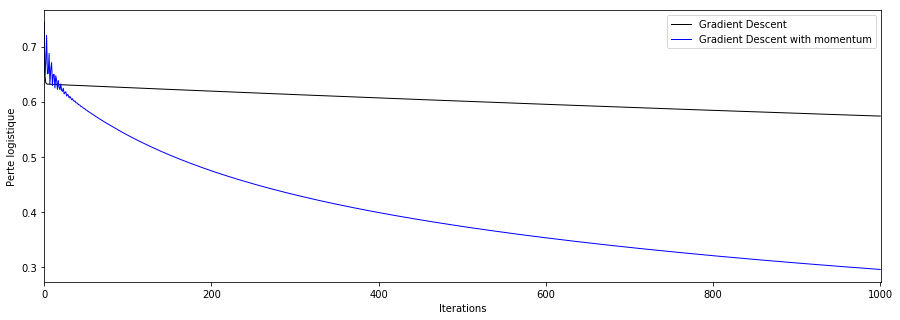

In [10]:
utilsLab1.iteration_plot(2, f=np.array([f_GD, f_GD_Momentum]).T,  
                         label=["Gradient Descent", 
                                "Gradient Descent with momentum"])

## Mini-Batch Gradient Descent

In [14]:
def miniBatchGD(data, w0=None, learningRate=0.02, momentum=0.0, nesterov=False, 
                lambda1=0.0, lambda2=0.0,
                iterations=10, sampleSize=100, progress=False):
    
    numFeatures = len(data.take(1)[0].features)
    trainSize = data.count()
    fraction = float(sampleSize)/float(trainSize)
    v = np.zeros(numFeatures)
    if w0 is None:
        w = np.random.normal(size=numFeatures)
    else:
        w = w0
    
    f = np.array([data.map(lambda ex: Ji(ex,w)).reduce(add)/trainSize + \
                  lambda1*np.linalg.norm(w,1) + 0.5*lambda2*np.dot(w,w)])
    
    ts = timeit.default_timer()
    
    for k in range(iterations):
        
        # choose randomly sampleSize examples (sampling)
        sampleRDD = trainRDD.sample(True, fraction)
        sampleSize = sampleRDD.count()
        
        if nesterov:
            w = w - momentum*v
        
        #wBroadcast = sc.broadcast(w)
        #gradient = sampleRDD.map(lambda ex: gradJi(ex,wBroadcast.value)).reduce(add)/sampleSize
        gradient = sampleRDD.map(lambda ex: gradJi(ex,w)).reduce(add)/sampleSize + \
                    lambda1*np.sum(np.divide(w, np.sqrt(1. + np.power(w,2)))) + \
                    lambda2*w
        v = momentum*v + learningRate*gradient
        w += -v
        
        fval = np.array([data.map(lambda ex: Ji(ex,w)).reduce(add)/trainSize + \
                         lambda1*np.linalg.norm(w,1) + 0.5*lambda2*np.dot(w,w)]) 
        f = np.vstack((f, fval))
        
        # progress trace
        if (progress==True) and (k%(iterations/10)==0):
            utilsLab1.show_progress2(k, fval, gradient)
    
    te =  timeit.default_timer()  
    
    if (progress==True):
        print("\n*** Mini-Batch Gradient Descent *** (", np.round(te-ts,2), "seconds)")
        utilsLab1.show_progress2(k, fval, gradient)
        
    return w,f.reshape(iterations+1,)

In [15]:
w_miniGD, f_miniGD = miniBatchGD(trainRDD.cache(), w0=np.array(W0),
                                 learningRate=LR, 
                                 #lambda1=0.01, lambda2=0.005,
                                 iterations=ITER_MAX, sampleSize=1000, progress=True)

epoch 1     f(w)=0.6504   Grad_f(w)=0.226295
epoch 101   f(w)=0.6265   Grad_f(w)=0.038310
epoch 201   f(w)=0.6194   Grad_f(w)=0.011333
epoch 301   f(w)=0.6130   Grad_f(w)=0.029347
epoch 401   f(w)=0.6075   Grad_f(w)=0.009436
epoch 501   f(w)=0.6011   Grad_f(w)=0.010769
epoch 601   f(w)=0.5954   Grad_f(w)=0.024081
epoch 701   f(w)=0.5901   Grad_f(w)=0.004656
epoch 801   f(w)=0.5844   Grad_f(w)=0.008110
epoch 901   f(w)=0.5791   Grad_f(w)=0.005473

*** Mini-Batch Gradient Descent *** ( 104.21 seconds)
epoch 1000  f(w)=0.5740   Grad_f(w)=0.011013


In [16]:
w_miniGD_m, f_miniGD_m = miniBatchGD(trainRDD.cache(), w0=np.array(W0),
                                     learningRate=LR, momentum=0.9, nesterov=True,
                                     #lambda1=0.01, lambda2=0.005,
                                     iterations=ITER_MAX, sampleSize=1000, progress=True)

epoch 1     f(w)=0.6523   Grad_f(w)=0.218787
epoch 101   f(w)=0.5392   Grad_f(w)=0.051618
epoch 201   f(w)=0.4744   Grad_f(w)=0.005429
epoch 301   f(w)=0.4310   Grad_f(w)=0.009631
epoch 401   f(w)=0.3990   Grad_f(w)=0.007142
epoch 501   f(w)=0.3737   Grad_f(w)=0.011609
epoch 601   f(w)=0.3529   Grad_f(w)=0.004084
epoch 701   f(w)=0.3393   Grad_f(w)=0.027426
epoch 801   f(w)=0.3205   Grad_f(w)=0.017979
epoch 901   f(w)=0.3073   Grad_f(w)=0.013041

*** Mini-Batch Gradient Descent *** ( 101.71 seconds)
epoch 1000  f(w)=0.2961   Grad_f(w)=0.015033


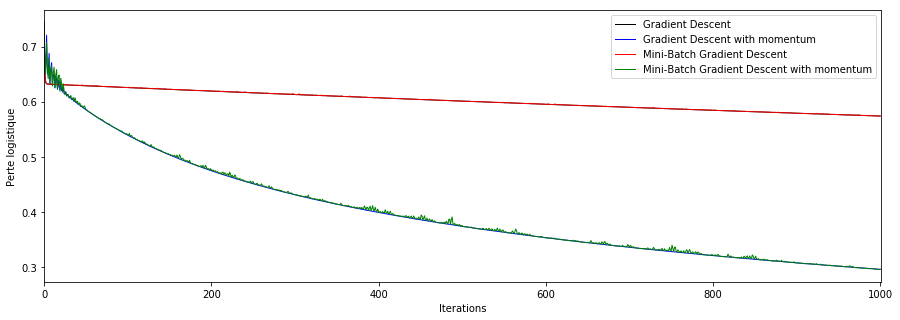

In [17]:
utilsLab1.iteration_plot(4, f=np.array([f_GD, f_GD_Momentum, f_miniGD, f_miniGD_m]).T,  
                         label=["Gradient Descent", 
                                "Gradient Descent with momentum", 
                                "Mini-Batch Gradient Descent",
                                "Mini-Batch Gradient Descent with momentum"])

In [18]:
wopt = w_miniGD_m
pred = testRDD.map(lambda ex: (ex.label == utilsLab1.prediction(ex.features,wopt))).collect()   
print("Prediction accuracy:", np.round(100.*sum(pred)/len(pred),2), "%")

Prediction accuracy: 94.37 %


Confusion matrix, without normalization
[[225  38]
 [  9 563]]


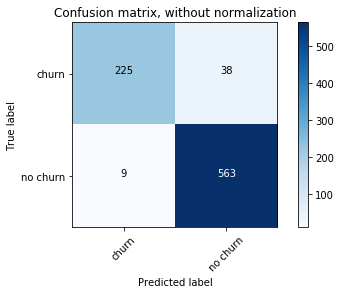

In [19]:
from sklearn.metrics import confusion_matrix

y_test = np.array(testRDD.map(lambda ex: ex.label).collect())
y_pred = np.array(testRDD.map(lambda ex: utilsLab1.prediction(ex.features,wopt,threshold=0.5)).collect())
cnf_matrix = confusion_matrix(y_test, y_pred)

# plot normalized confusion matrix
class_names = ["churn", "no churn"]
plt.figure()
utilsLab1.plot_confusion_matrix(cnf_matrix, classes=class_names,
                                title='Confusion matrix, without normalization')

plt.show()

In [20]:
# stop Spark
sc.stop()

# Références

[1] HOGWILD!: A Lock-Free Approach to Parallelizing Stochastic Gradient Descent. Feng Niu, Benjamin Recht, Christopher Re, Stephen J. Wright - http://arxiv.org/abs/1106.5730

[2] [Downpour SGD](http://static.googleusercontent.com/media/research.google.com/en//archive/large_deep_networks_nips2012.pdf) - Jeffrey Dean, Greg S. Corrado, Rajat Monga, Kai Chen, Matthieu Devin, Quoc V. Le, Mark Z. Mao, Marc Aurelio Ranzato, Andrew Senior, Paul Tucker, Ke Yang, and Andrew Y. Ng. Large Scale Distributed Deep Networks. NIPS 2012: Neural Information Processing Systems, pages 1–11, 2012.